In [ ]:
import torch
import numpy as np
from itertools import combinations
import tqdm

In [ ]:
def select_dict(dicts, hparam_name, hparam_value):
    closest_hparam_dist = float("inf")
    closest_dict = None
    closest_val = None

    for dict, hparam in dicts:
        hparam_dist = abs(hparam[hparam_name] - hparam_value)
        if hparam_dist < closest_hparam_dist:
            closest_hparam_dist = hparam_dist
            closest_dict = dict
            closest_val = hparam[hparam_name]
    
    return closest_dict, closest_val

In [ ]:
#upstream_dicts = torch.load("/home/mchorse/sparse_coding_hoagy/tiedlong_tied_residual_l3_r4/_80/learned_dicts.pt")
#downstream_dicts = torch.load("/home/mchorse/sparse_coding_hoagy/tiedlong_tied_residual_l4_r4/_80/learned_dicts.pt")

upstream_dicts = torch.load("/mnt/ssd-cluster/bigrun0308/tied_residual_l2_r4/_9/learned_dicts.pt")
downstream_dicts = torch.load("/mnt/ssd-cluster/bigrun0308/tied_residual_l3_r4/_9/learned_dicts.pt")

target_l1 = 8e-4

upstream_dict, l1_up = select_dict(upstream_dicts, "l1_alpha", target_l1)
downstream_dict, l1_down = select_dict(downstream_dicts, "l1_alpha", target_l1)

print(f"MLP out L1: {l1_up}")
print(f"Residual stream L1: {l1_down}")

upstream_feats = upstream_dict.get_learned_dict()
downstream_feats = downstream_dict.get_learned_dict()

upstream_zero_l1_baseline, true_baseline_l1 = select_dict(upstream_dicts, "l1_alpha", 0.0)

print(f"Upstream zero L1 baseline: {true_baseline_l1}")

MLP out L1: 0.0008576958789490163
Residual stream L1: 0.0008576958789490163
Upstream zero L1 baseline: 9.999999747378752e-05


In [ ]:
# thanks stack overflow
def gini(x):
    x.sort()
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [ ]:
# already normed
cosine_sim = torch.abs(torch.einsum("md,rd->mr", upstream_feats, downstream_feats))
baseline_cosine_sim = torch.abs(torch.einsum("md,rd->mr", upstream_zero_l1_baseline.get_learned_dict(), downstream_feats))

In [ ]:
up_gini = []
for f_idx in tqdm.tqdm(range(cosine_sim.shape[0])):
    #up_gini.append(gini(cosine_sim[f_idx].cpu().numpy()))
    continue

rand_gini = []
for f_idx in tqdm.tqdm(range(baseline_cosine_sim.shape[0])):
    #rand_gini.append(gini(baseline_cosine_sim[f_idx].cpu().numpy()))
    continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:00<00:00, 6716133.38it/s]


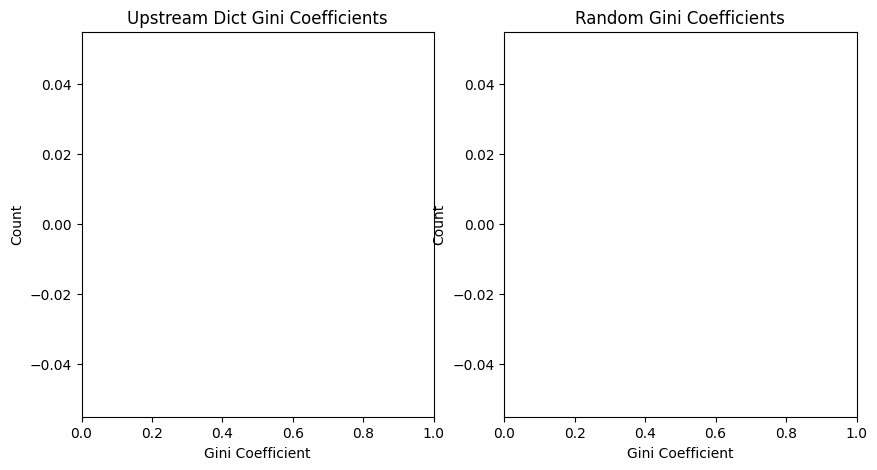

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(up_gini, bins=100)
ax1.set_title("Upstream Dict Gini Coefficients")
ax1.set_xlabel("Gini Coefficient")
ax1.set_ylabel("Count")
ax1.set_xlim(0, 1)

ax2.hist(rand_gini, bins=100)
ax2.set_title("Random Gini Coefficients")
ax2.set_xlabel("Gini Coefficient")
ax2.set_ylabel("Count")
ax2.set_xlim(0, 1)

plt.show()
plt.close(fig)

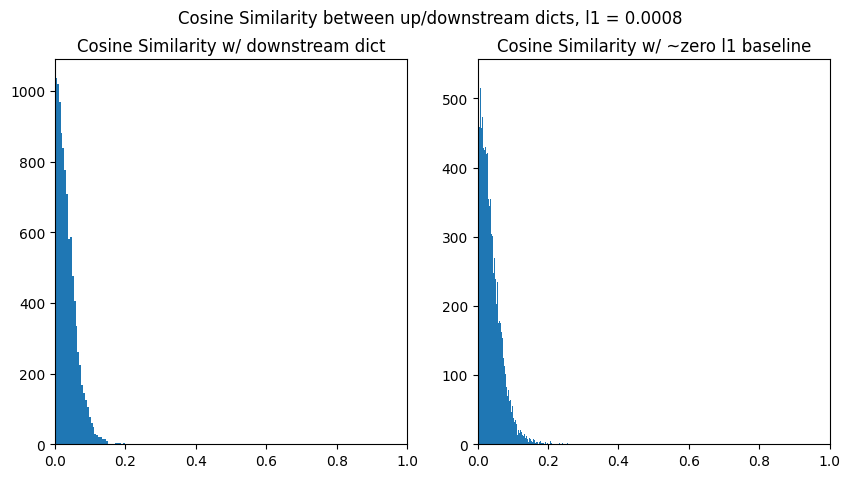

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle(f"Cosine Similarity between up/downstream dicts, l1 = {target_l1}")

sample_size = 10000

sample_idxs = np.random.choice(len(cosine_sim.flatten()), size=sample_size, replace=False)

ax1.hist(cosine_sim.flatten()[sample_idxs], bins=100)
ax1.set_title("Cosine Similarity w/ downstream dict")
ax1.set_xlim(0, 1)

ax2.hist(baseline_cosine_sim.flatten()[sample_idxs], bins=100)
ax2.set_title("Cosine Similarity w/ ~zero l1 baseline")
ax2.set_xlim(0, 1)

plt.show()
plt.close(fig)

In [ ]:
upstream_activation_data = torch.load("activation_data/layer_2/0.pt").to("cuda:0", dtype=torch.float32)
downstream_activation_data = torch.load("activation_data/layer_3/0.pt").to("cuda:0", dtype=torch.float32)

In [ ]:
from autoencoders.learned_dict import RandomDict

upstream_zero_l1_baseline = RandomDict(activation_size=512, n_feats=512)

In [ ]:
# iteratively build covariance matrixes for encodings

covariance = torch.zeros(upstream_feats.shape[0], downstream_feats.shape[0], device="cuda:0")
covariance_to_baseline = torch.zeros(upstream_zero_l1_baseline.n_dict_components(), downstream_feats.shape[0], device="cuda:0")

means_upstream = torch.zeros(upstream_feats.shape[0], device="cuda:0")
means_downstream = torch.zeros(downstream_feats.shape[0], device="cuda:0")
means_baseline = torch.zeros(upstream_zero_l1_baseline.n_dict_components(), device="cuda:0")

var_upstream = torch.zeros(upstream_feats.shape[0], device="cuda:0")
var_downstream = torch.zeros(downstream_feats.shape[0], device="cuda:0")
var_baseline = torch.zeros(upstream_zero_l1_baseline.n_dict_components(), device="cuda:0")

batch_size = 100000

upstream_dict.to_device("cuda:0")
downstream_dict.to_device("cuda:0")
upstream_zero_l1_baseline.to_device("cuda:0")

for i in tqdm.tqdm(range(0, upstream_activation_data.shape[0], batch_size)):
    j = min(i+batch_size, upstream_activation_data.shape[0])
    upstream_batch = upstream_activation_data[i:j]
    downstream_batch = downstream_activation_data[i:j]

    upstream_codes = upstream_dict.encode(upstream_batch)
    baseline_codes = upstream_zero_l1_baseline.encode(upstream_batch)

    downstream_codes = downstream_dict.encode(downstream_batch)

    means_upstream = (i / j) * means_upstream + ((j - i) / j) * upstream_codes.sum(dim=0)
    means_downstream = (i / j) * means_downstream + ((j - i) / j) * downstream_codes.sum(dim=0)
    means_baseline = (i / j) * means_baseline + ((j - i) / j) * baseline_codes.sum(dim=0)

    var_upstream = (i / j) * var_upstream + ((j - i) / j) * (upstream_codes - means_upstream).pow(2).sum(dim=0)
    var_downstream = (i / j) * var_downstream + ((j - i) / j) * (downstream_codes - means_downstream).pow(2).sum(dim=0)
    var_baseline = (i / j) * var_baseline + ((j - i) / j) * (baseline_codes - means_baseline).pow(2).sum(dim=0)

    covariance *= (i / j)
    covariance += ((j - i) / j) * ((upstream_codes - means_upstream).T @ (downstream_codes - means_downstream))

    covariance_to_baseline *= (i / j)
    covariance_to_baseline += ((j - i) / j) * ((baseline_codes - means_baseline).T @ (downstream_codes - means_downstream))

correlations = covariance / torch.sqrt(torch.outer(var_upstream, var_downstream))
correlations_to_baseline = covariance_to_baseline / torch.sqrt(torch.outer(var_baseline, var_downstream))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
up_gini = []
for f_idx in tqdm.tqdm(range(covariance.shape[0])):
    if (covariance[f_idx] == 0).all():
        continue
    up_gini.append(gini(np.abs(covariance[f_idx].cpu().numpy())))
    continue

base_gini = []
for f_idx in tqdm.tqdm(range(covariance_to_baseline.shape[0])):
    if (covariance_to_baseline[f_idx] == 0).all():
        continue
    base_gini.append(gini(np.abs(covariance_to_baseline[f_idx].cpu().numpy())))
    continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:15<00:00, 133.27it/s]


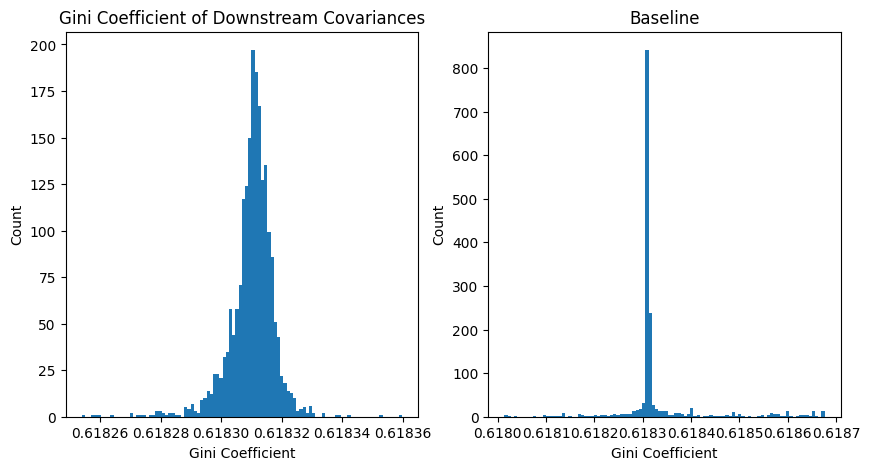

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(up_gini, bins=100)
ax1.set_title("Gini Coefficient of Downstream Covariances")
ax1.set_xlabel("Gini Coefficient")
ax1.set_ylabel("Count")

ax2.hist(base_gini, bins=100)
ax2.set_title("Baseline")
ax2.set_xlabel("Gini Coefficient")
ax2.set_ylabel("Count")

plt.show()
plt.close(fig)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


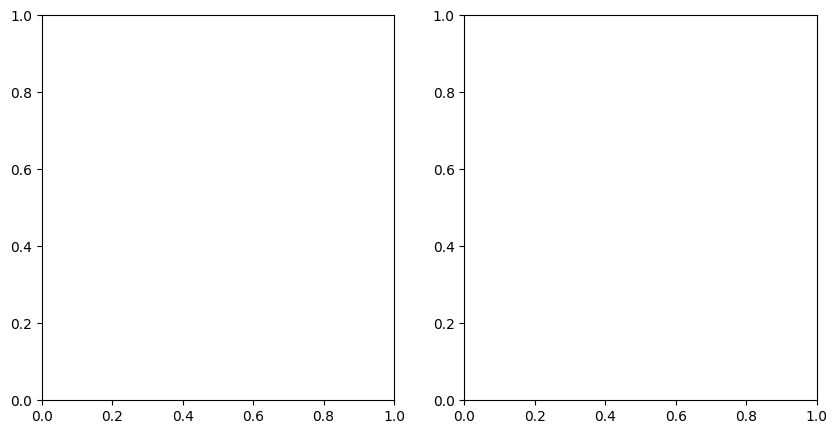

In [ ]:
n_samples = 10000
sample_idxs = np.random.choice(correlations.flatten().shape[0], size=n_samples, replace=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(correlations.flatten()[sample_idxs].cpu().numpy(), bins=100)
ax1.set_title("Correlation to dict")
ax1.set_xlabel("Correlation")

ax2.hist(correlations_to_baseline.flatten()[sample_idxs].cpu().numpy(), bins=100)
ax2.set_title("Correlation to baseline")
ax2.set_xlabel("Correlation")

plt.show()
plt.close(fig)